# Lecture 6, Data science in Neuroscience

## Plan for today

1. Graphical overview of what we have done so far
2. Analysis of spatially selective neurons
    1. Loading spike trains and position data.
    2. Analysis on spike trains (mean firing rate, instantaneous firing rate, inter-spike intervals)
    3. Analysis on position data
    4. Firing rate map of neurons

***

## Graphical overview

### Spike detection from filtered signals


* The signal was first filtered and we detected negative deflections as spikes. 
* The time associated with each spike was saved. 
* We extracted the waveform of each spike for clustering.

<div>
<img src="../images/spike_detection.png" width="1200"/>
</div>

### Spike clustering using the k-means algorithm


* The waveforms of the detected spikes were transform using principal component analysis (PCA) to reduce the dimentionality of the data.
* k-means clustering was used to group similar spike waveform together.
* Each cluster represents a "putative" neuron.
* We have the spike times (spike trains) of each neuron.

<div>
<img src="../images/pca.png" width="1200"/>
</div>


### Position tracking

* We trained a deep neural network to track the position of a mouse.
* The trained network can be used to extract the position of the mouse in new videos.
<div>
<img src="../images/dlc_path.png"/>
</div>



# Today: Tuning curve of a neuron

A common task in electrophysiology is to calculate the tuning curve of a neuron. 

The variables explaining the firing rate of neurons depends on the brain regions and cell types.

Here are some examples:

* Visual cortex: Firing rate as a function of the orientation of bars in the receptive field of the neuron.
* Auditory cortex: firing rate as a function of sound frequency.
* Presubiculum: firing rate as a function of head-direction.
* Entorhinal cortex and hippocampus: firing rate as a function of the position of the animal.


## Firing rate as a function of the position of an animal
We will combine the spike trains of neurons with the animal position to assess whether the activity of neurons is modulated by the position of an animal.

You will learn to generate this sort figures (Form Hafting et al., 2005).


<div>
<img src="../images/natureMoserFullPage.png" width="600"/>
</div>


# Loading our small dataset

The dataset contains the spike trains of 5 neurons recorded in the medial entorhinal cortex as the animal explored a 70x70 square box for 20 minutes (Thanks to Beate Throm for sharing this data).

The data is saved as a `pickle` object. [More information on the pickle module](https://docs.python.org/3/library/pickle.html)

I used pickle to save a dictionary containing our dataset.


Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.

In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

fn="../data/gridCellData.pickle" # name of our data file


with open(fn, "rb") as myFile: # with statement, will close the file automatically when we are done
    myData = pickle.load(myFile)

The dataset is now stored in `myData`. 

## Exercise 1:  Investigate how the data is structure

* What type of object is myData?
* What does myData contain?
* How many spike trains are in the data set?
* How can you access one spike train?
* How can you access the x and y position of the animal?

# Analysis on spike trains

## Mean firing rate

The mean firing rate of a neuron is the number of spikes by unit of time (usually seconds).


$Rate = spikes/seconds$

The recording was 1243 seconds.

What is the mean firing rate of our 5 neurons?

In [47]:
duration = 1243

In [48]:
stList = myData["spike_trains"]

In [49]:
stList[0].shape[0]

2846

In [50]:
stList[0].shape[0]/duration

2.2896218825422365

In [57]:
for a in stList:
    print("{:.2f} Hz".format(a.shape[0]/duration))

2.29 Hz
6.33 Hz
4.15 Hz
3.90 Hz
7.27 Hz


## Instantaneous firing rate

It is often useful to know the firing rate of a neuron at different points in time. 

This is usually done by :
1. Counting the number of spikes in 1 ms bins
2. Applying a gaussian filter to the array


You need to count the number of occurances in a set of bins. This is the equivalent of calculating a histogram.

We can use NumPy [histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) function to get our histogram.

In [99]:
bins = np.arange(start=0,stop=duration,step=0.001)
st = stList[0]
counts, edges = np.histogram(a = st,bins=bins)

Text(0, 0.5, 'Spikes')

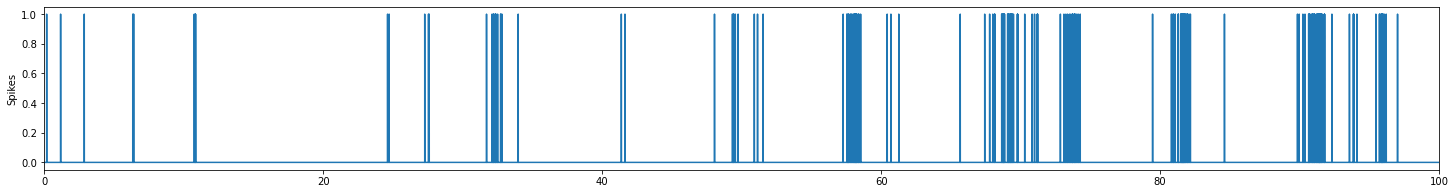

In [100]:
plt.figure(figsize=(25,3))
plt.plot(bins[1:],counts)
plt.xlim(0,100)
plt.ylabel("Spikes")

We get either 0 or 1 spike per bin. Now we can apply a gaussian filter

In [101]:
from scipy.ndimage.filters import gaussian_filter
ifr = gaussian_filter(counts.astype("float"),sigma=100)
ifr = ifr*1000 # to transform to Hz

Text(0, 0.5, 'Firing rate (Hz)')

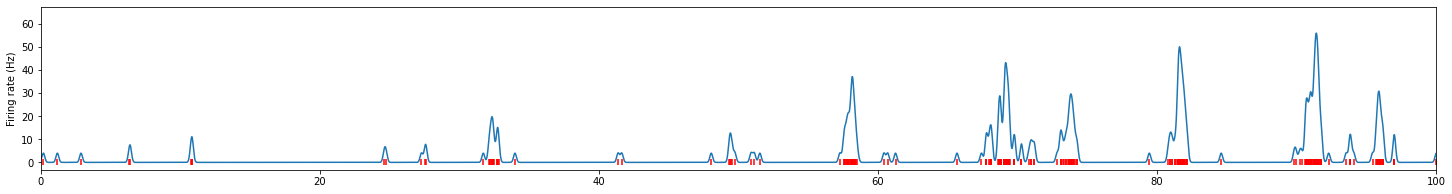

In [103]:
plt.figure(figsize=(25,3))
plt.plot(bins[1:],ifr)
plt.scatter(st,np.zeros_like(stList[0]),c="red",marker='|')
plt.xlim(0,100)
plt.ylabel("Firing rate (Hz)")

You could then use this firing rate array for further analysis. For instance as in Lecture 4 when we modelled a speed cell.

## Inter-spike intervals

The inter-spike intervals are just the time difference between adjacent spikes in a spike train.

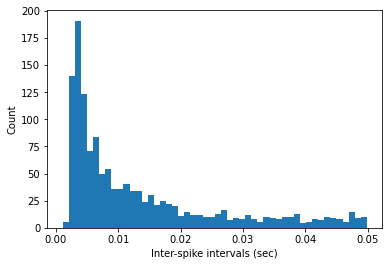

In [119]:
st = stList[0]
std = np.diff(st)
std = std[std<0.050]
plt.hist(std,bins=50)
plt.xlabel("Inter-spike intervals (sec)")
plt.ylabel("Count")
plt.show()

# Position of the animal during recordings

In the current data set, we have the position of the animal (x,y) in time. This is stored in `myData["position"]`

In [120]:
myData["position"]

{'time': array([0.00000e+00, 2.00000e-02, 4.00000e-02, ..., 1.24332e+03,
        1.24334e+03, 1.24336e+03]),
 'x': array([nan, nan, nan, ..., nan, nan, nan]),
 'y': array([nan, nan, nan, ..., nan, nan, nan])}

## Exercise 2: Plot the path of the animal (x,y) during the recording session.

In [121]:
p = myData["position"]
p

{'time': array([0.00000e+00, 2.00000e-02, 4.00000e-02, ..., 1.24332e+03,
        1.24334e+03, 1.24336e+03]),
 'x': array([nan, nan, nan, ..., nan, nan, nan]),
 'y': array([nan, nan, nan, ..., nan, nan, nan])}

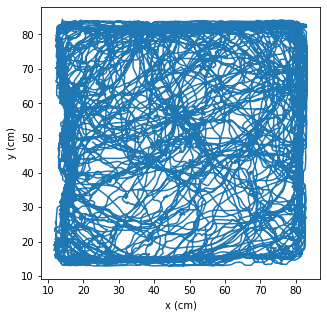

In [122]:
plt.figure(figsize=(5,5))
plt.plot(p["x"],p["y"])
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

# Firing rate map of a neuron

1. Occupancy map
2. Position of the animal associated with each spike
3. Firing rate map

## Occupancy map 

Imagine that we divide the space explored by the animal in 2x2 cm bins. The occupancy map represent the time in second that the animal spent in each bin.

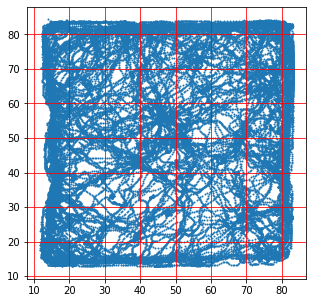

In [123]:
plt.figure(figsize=(5,5))
plt.scatter(p["x"],p["y"],s=1)
plt.grid(c="red",zorder=3)

You need to count the number of occurances in a set of bins. This is the same as calculating a histogram, but in 2D.

Calculating histogram is very common operation. This means that the function has probably been writen and tested before. For instance, `matplotlib` and `numpy` have functions to calculate histograms.

You can start with solving the problem in 1D and then apply what you learned to 2D. 

Let's start with the x position only.

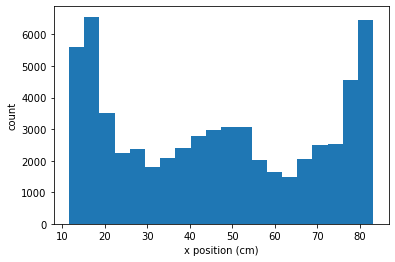

In [124]:
plt.hist(p["x"],bins=20)
plt.xlabel("x position (cm)")
plt.ylabel("count")
plt.show()

In [125]:
np.histogram(p["x"])

ValueError: autodetected range of [nan, nan] is not finite

We get this error because our data contain `np.nan`. We can either set the bins when calling the function, or removing the np.nan from our data.

In [135]:
bins = np.arange(start=10,stop=90+2,step=2)
bins

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76,
       78, 80, 82, 84, 86, 88, 90])

In [136]:
np.histogram(p["x"],bins=bins)

(array([  19, 2694, 4912, 3137, 2818, 1738, 1485, 1156, 1271, 1276,  954,
        1114, 1200, 1149, 1498, 1450, 1666, 1525, 1725, 1839, 1718, 1751,
        1267, 1072,  993,  815,  815,  851, 1144, 1478, 1344, 1420, 1400,
        1978, 3259, 4513, 1278,    0,    0,    0]),
 array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
        44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76,
        78, 80, 82, 84, 86, 88, 90]))

In [137]:
counts, bins = np.histogram(p["x"],bins = bins)

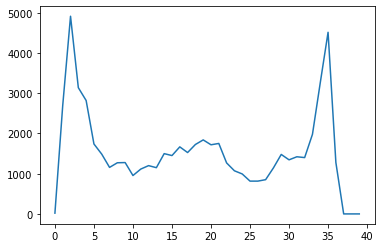

In [138]:
plt.plot(counts)

## Exercise 3: 
* Use the NumPy [histogram2d](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html) function to create an occupancy map from the position data (x,y).
* Plot the results (2D array)

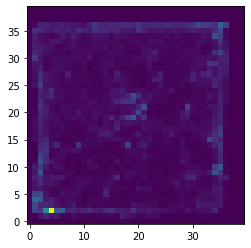

In [139]:
occMap, binsx, binsy = np.histogram2d(p["x"],p["y"],bins=bins)
plt.imshow(occMap.T,origin="lower")
plt.show()

## Exercise 4: The values in `occMap` are counts. Transform this from counts to seconds.

The time interval between position data points is constant. You can get the time per position data using the code below.

In [140]:
deltaTime = p["time"][1]-p["time"][0]
print("Time per data point: {} sec".format(deltaTime))

Time per data point: 0.02 sec


Transform the values from counts to seconds.

In [141]:
occMap = occMap*deltaTime

We could set the bins that are never visited by the animal (time of 0 second) to np.nan

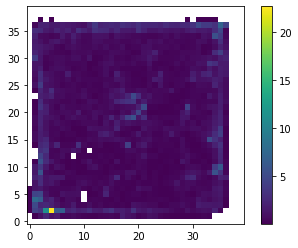

In [142]:
occMapNan = occMap.copy()
occMapNan[occMapNan==0.0] = np.nan

plt.imshow(occMapNan.T,origin="lower")
plt.colorbar()
plt.show()


## Position of the animal associated with each spike

We have the position of the animal at fixed time intervals. 

We need to find the x and y position of the animal at specific time points, which likely fall between our position data points.

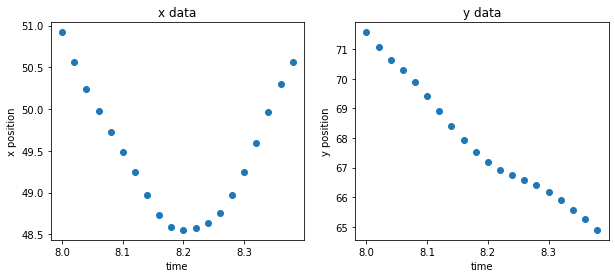

In [143]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(p["time"][400:420],p["x"][400:420])
ax[0].set_xlabel("time")
ax[0].set_ylabel("x position")
ax[0].set_title("x data")

ax[1].scatter(p["time"][400:420],p["y"][400:420])
ax[1].set_xlabel("time")
ax[1].set_ylabel("y position")
ax[1].set_title("y data")

plt.show()

We can use linear interpolation to do this.

Scipy has a few interpolation functions: [scipy.interpolate.interp1d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

Here is just an example to show that we can get the position at any time point using interpolation.

In [144]:
from scipy.interpolate import interp1d

newTime = np.linspace(0,10,10000)

fx = interp1d(p["time"], p["x"]) # create function that will interpolate

xOfNewTime = fx(newTime) # interpolate

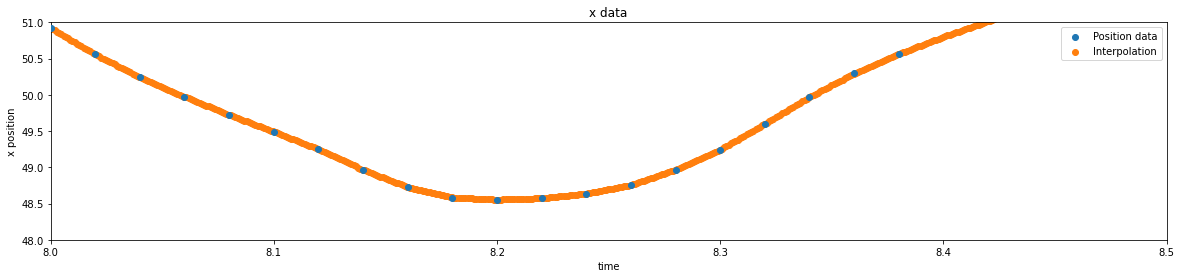

In [145]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

ax.scatter(p["time"][400:420],p["x"][400:420], zorder=3, label="Position data")
ax.scatter(newTime,xOfNewTime,zorder=2,label="Interpolation")
ax.set_xlim(8,8.5)
ax.set_ylim(48,51)
ax.set_xlabel("time")
ax.set_ylabel("x position")
ax.set_title("x data")
ax.legend()
plt.show()

## Exercise 5

Get the x and y position of the animal for the spike of the third neuron (`myData["spike_trains"][3]`). Plot the position of each spike.

In [146]:
st = myData["spike_trains"][3]

fx = interp1d(p["time"], p["x"]) # create function that will interpolate
fy = interp1d(p["time"], p["y"]) # create function that will interpolate

spikeX = fx(st)
spikeY = fy(st)

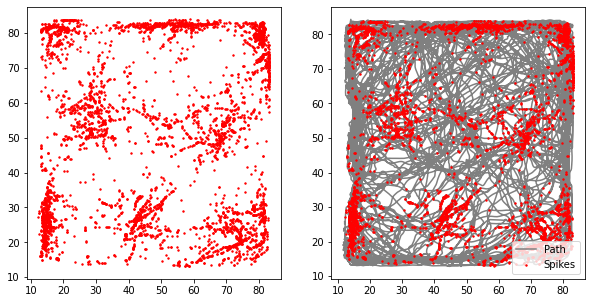

In [147]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(spikeX,spikeY,s=2,c="red")

ax[1].plot(p["x"],p["y"],c="grey",zorder=1,label="Path")
ax[1].scatter(spikeX,spikeY,s=2,c="red",zorder=3,label="Spikes")
ax[1].legend()

plt.show()

## Firing rate map of a neuron

A firing rate map contains the firing rate of a neuron at different locations (bins).

The firing rate is defined as the number of spikes per second (Hz).

$Rate = spikes/sec$

The occupancy map contains the time in seconds at different locations. 

All we need is the number of spikes in these same bins. We can use the NumPy function `histogram2d` to get the spike counts in bins.

In [148]:
nSpikes, binsx, binsy = np.histogram2d(spikeX,spikeY,bins=bins)

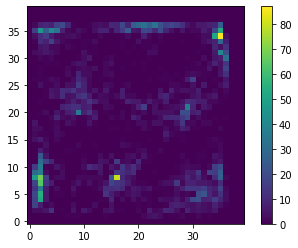

In [149]:
plt.imshow(nSpikes.T,origin="lower")
plt.colorbar()
plt.show()

In [150]:
firingRateMap = nSpikes/occMapNan

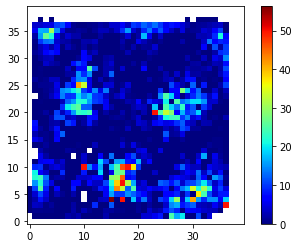

In [151]:
plt.imshow(firingRateMap.T,origin="lower",cmap="jet")
plt.colorbar()
plt.show()

## Applying smoothing to the firing rate map

Because the recording period is not very long (20 minutes), there is considerable "noise" in our estimate of firing rate. We can apply a Gaussian filter to smooth the map. 

In [152]:
from scipy.ndimage.filters import gaussian_filter
    
sOccMap = gaussian_filter(occMap, sigma=1.5)
snSpikes = gaussian_filter(nSpikes, sigma=1.5)

Text(0.5, 1.0, 'Smoothed spike count')

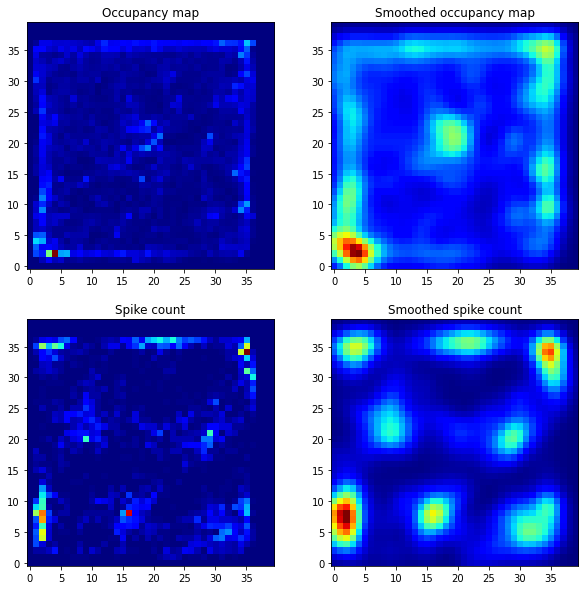

In [153]:
fig,ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(occMap.T,origin="lower",cmap="jet")
ax[0,0].set_title("Occupancy map")
ax[0,1].imshow(sOccMap.T,origin="lower",cmap="jet")
ax[0,1].set_title("Smoothed occupancy map")

ax[1,0].imshow(nSpikes.T,origin="lower",cmap="jet")
ax[1,0].set_title("Spike count")
ax[1,1].imshow(snSpikes.T,origin="lower",cmap="jet")
ax[1,1].set_title("Smoothed spike count")

In [154]:
sOccMap[occMap==0.0] = np.nan # remove the values that were 0 in the occupancy map before smoothing

sFiringRateMap = snSpikes/sOccMap


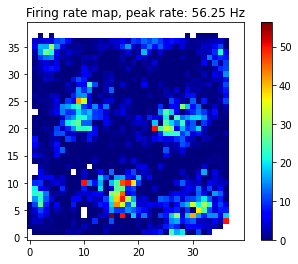

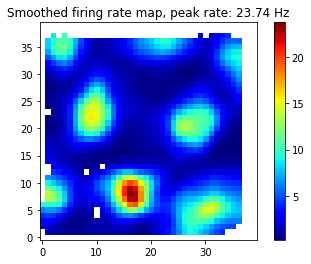

In [155]:
plt.imshow(firingRateMap.T,origin="lower",cmap="jet")
plt.colorbar()
plt.title("Firing rate map, peak rate: {:.2f} Hz".format(np.nanmax(firingRateMap)))
plt.show()

plt.imshow(sFiringRateMap.T,origin="lower",cmap="jet")
plt.colorbar()
plt.title("Smoothed firing rate map, peak rate: {:.2f} Hz".format(np.nanmax(sFiringRateMap)))
plt.show()

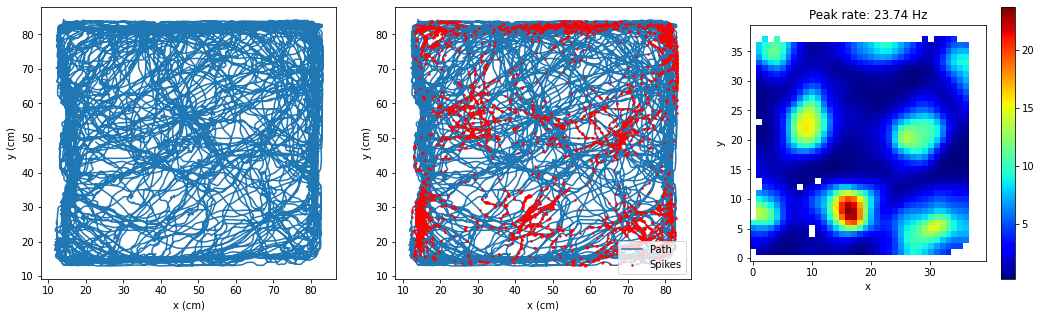

In [161]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(p["x"],p["y"],label="Path")
ax[0].set_xlabel("x (cm)")
ax[0].set_ylabel("y (cm)")

ax[1].plot(p["x"],p["y"],label="Path")
ax[1].scatter(spikeX,spikeY,s=2,c="red",zorder=3,label="Spikes")
ax[1].set_xlabel("x (cm)")
ax[1].set_ylabel("y (cm)")
ax[1].legend()


im = ax[2].imshow(sFiringRateMap.T,origin="lower",cmap="jet")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Peak rate: {:.2f} Hz".format(np.nanmax(sFiringRateMap)))
plt.colorbar(im)

fn = "../images/gridCellExample.png"
plt.savefig(fn)
plt.show()